In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

C:\Users\nito8\AppData\Local\Temp\ipykernel_17192\3715944401.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
[*********************100%***********************]  2 of 2 completed


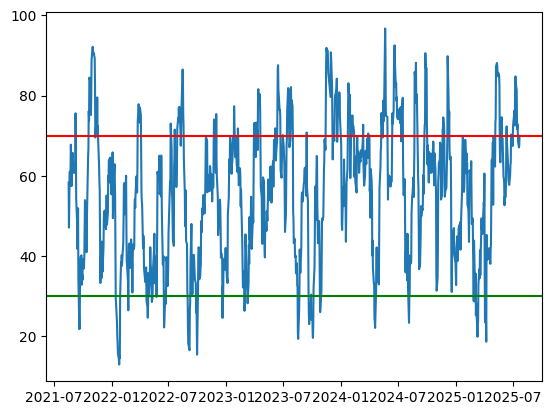

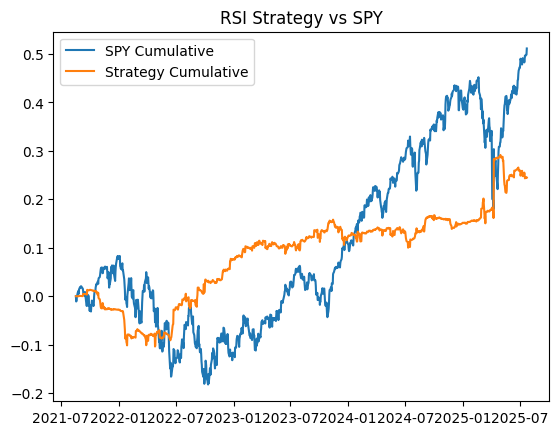

In [4]:
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000
TICKER = 'SPY'
CASH_TICKER = 'SHY'

def get_data(ticker=TICKER, cash_ticker=CASH_TICKER, lookback = LOOKBACK):
    df = yf.download([ticker, cash_ticker], period="max")['Close'].ffill()
    df.columns = df.columns.get_level_values(0)
    return df.iloc[-lookback:, :]

def add_RSI(df, ticker=TICKER, cash_ticker=CASH_TICKER, length=RSI_LENGTH):

    price_change = df[ticker].diff()
    
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')

    return df.dropna()

def add_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    df['Strategy'] = df['Strategy'].shift(1).fillna(0)
    return df

def test_strategy(df, ticker=TICKER, cash_ticker=CASH_TICKER):

    asset_rets = df[ticker].pct_change().fillna(0)
    cash_rets  = df[cash_ticker].pct_change().fillna(0)

    strat_daily = np.where(
        df['Strategy'] == 0,
        cash_rets,
        asset_rets * df['Strategy']
    )

    df['Asset_Returns'] = (1 + asset_rets).cumprod() - 1
    df['Strategy_Returns'] = (1 + strat_daily).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_Returns'], label = f'{ticker} Cumulative')
    plt.plot(df['Strategy_Returns'], label = 'Strategy Cumulative')
    plt.legend()
    plt.title(f'RSI Strategy vs {ticker}')
    plt.show()

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return df

df = main()